## Group assignment

In [ ]:
pip install rdkit-pypi

### loading data

In [40]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [34]:
file_path = './tested_molecules.csv'
data = pd.read_csv(file_path)

# Convert inhibition columns to integers
data["PKM2_inhibition"] = data["PKM2_inhibition"].astype(int)
data["ERK2_inhibition"] = data["ERK2_inhibition"].astype(int)
data

,SMILES,PKM2_inhibition,ERK2_inhibition
0,C=C(C)c1nc(N)nc(N)n1,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0
...,...,...,...
1111,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,0,1
1112,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,0,1
1113,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,0,1
1114,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1,0,1


### Calculating some molecular descriptions

In [48]:
#Physicochemical properties
# Function to compute molecular properties
def compute_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol_weight = Descriptors.MolWt(mol)
        h_bond_acceptors = int(Descriptors.NumHAcceptors(mol))
        h_bond_donors = int(Descriptors.NumHDonors(mol))
        tpsa = Descriptors.TPSA(mol)
        return pd.Series([mol_weight, h_bond_acceptors, h_bond_donors, tpsa])
    else:
        return pd.Series([None, None, None, None])

# Apply the function to the 'SMILES' column
data[['molecular_weight', 'h_bond_acceptors', 'h_bond_donors', 'TPSA']] = data['SMILES'].apply(compute_properties)

# Ensure proper integer data types for the hydrogen bond columns
data['h_bond_acceptors'] = data['h_bond_acceptors'].astype(pd.Int64Dtype())
data['h_bond_donors'] = data['h_bond_donors'].astype(pd.Int64Dtype())

In [49]:
#Counters of pre-defined substructures
def num_aromatic_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        aromatic_rings = 0
        for ring in mol.GetRingInfo().AtomRings():
            if all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring):
                aromatic_rings += 1
        return aromatic_rings
    return None

def num_rotatable_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return rdMolDescriptors.CalcNumRotatableBonds(mol)
    return None

#applying functions to dataframe
data['num_aromatic_rings'] = data['SMILES'].apply(num_aromatic_rings)
data['num_rotatable_bonds'] = data['SMILES'].apply(num_rotatable_bonds)
data

,SMILES,PKM2_inhibition,ERK2_inhibition,molecular_weight,h_bond_acceptors,h_bond_donors,TPSA,num_aromatic_rings,num_rotatable_bonds,Morgan_Fingerprint,MACCS_Keys
0,C=C(C)c1nc(N)nc(N)n1,0,0,151.173,5,2,90.71,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,250.681,3,0,39.44,2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,210.277,2,2,58.20,0,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,232.239,4,0,58.17,2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,226.663,4,0,44.00,1,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
1111,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,0,1,362.385,5,1,63.94,3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1112,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,0,1,374.442,4,1,64.72,4,4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1113,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,0,1,355.849,4,2,53.69,3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1,0,1,322.437,5,0,32.26,3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [50]:
#Binary fingerprints
# Function to compute Morgan fingerprint
def compute_morgan_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return list(fp)  # Convert to list for easier handling
    else:
        return None

# Function to compute MACCS keys
def compute_maccs_keys(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        keys = MACCSkeys.GenMACCSKeys(mol)
        return list(keys)  # Convert to list for easier handling
    else:
        return None

# Apply functions to the SMILES column and create new columns
data['Morgan_Fingerprint'] = data['SMILES'].apply(compute_morgan_fp)
data['MACCS_Keys'] = data['SMILES'].apply(compute_maccs_keys)

## Exploratory data analysis

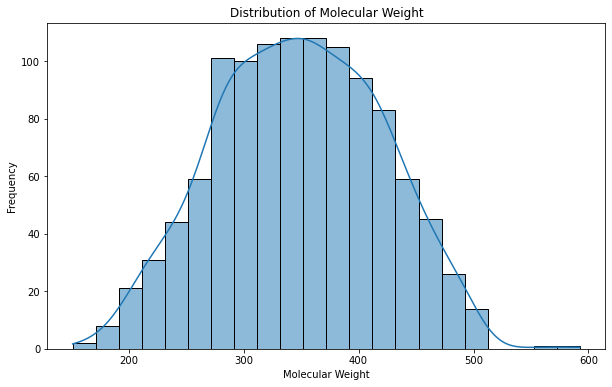

ValueError: object arrays are not supported

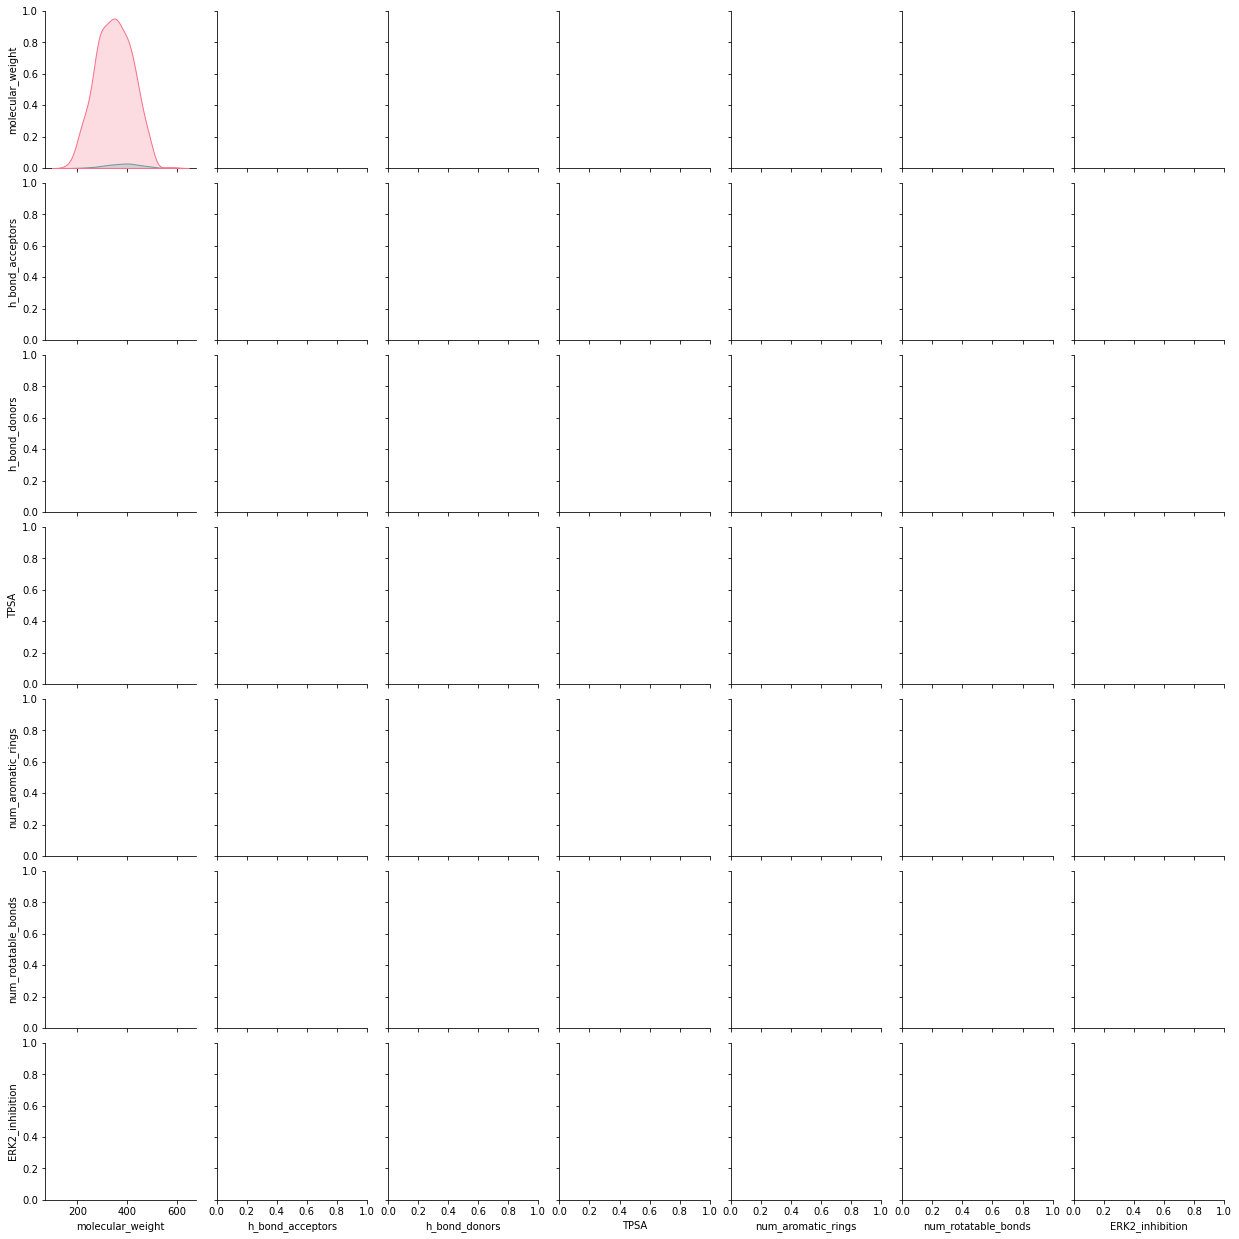

In [67]:
# Visualize distributions of molecular descriptors
plt.figure(figsize=(10, 6))
sns.histplot(data['molecular_weight'], kde=True)
plt.title('Distribution of Molecular Weight')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.show()

# Pair plots for molecular descriptors with color differentiation
sns.pairplot(data[["molecular_weight", "h_bond_acceptors", "h_bond_donors", "TPSA", "num_aromatic_rings", "num_rotatable_bonds", "PKM2_inhibition", "ERK2_inhibition"]], hue="PKM2_inhibition", palette="husl")
plt.show()

# Calculate the correlation matrix
corr_matrix = data[["PKM2_inhibition", "ERK2_inhibition", "molecular_weight", "h_bond_acceptors", "h_bond_donors", "TPSA", "num_aromatic_rings", "num_rotatable_bonds", "Morgan_Fingerprint", "MACCS_Keys"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# Summarize and visualize fingerprint data
data['Morgan_Fingerprint'] = data['Morgan_Fingerprint'].apply(lambda x: np.array(x))
data['MACCS_Keys'] = data['MACCS_Keys'].apply(lambda x: np.array(x))

# Example of visualizing the sum of fingerprint bits with color differentiation
morgan_sum = np.sum(np.stack(data['Morgan_Fingerprint'].values), axis=0)
maccs_sum = np.sum(np.stack(data['MACCS_Keys'].values), axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(morgan_sum)), morgan_sum, color=['blue' if i == 0 else 'red' for i in data['PKM2_inhibition']])
plt.title('Morgan Fingerprint Bit Counts')
plt.xlabel('Bit Position')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(range(len(maccs_sum)), maccs_sum, color=['blue' if i == 0 else 'red' for i in data['PKM2_inhibition']])
plt.title('MACCS Keys Bit Counts')
plt.xlabel('Bit Position')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### outlier analysis

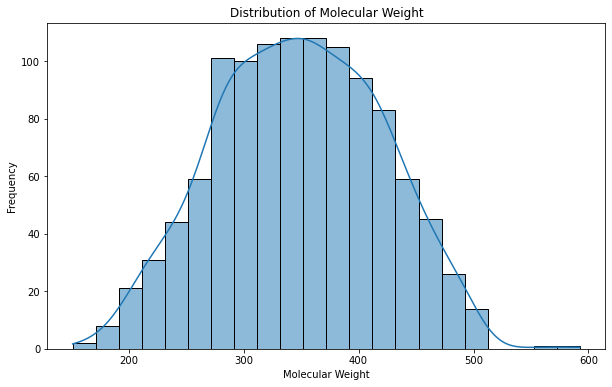

ValueError: object arrays are not supported

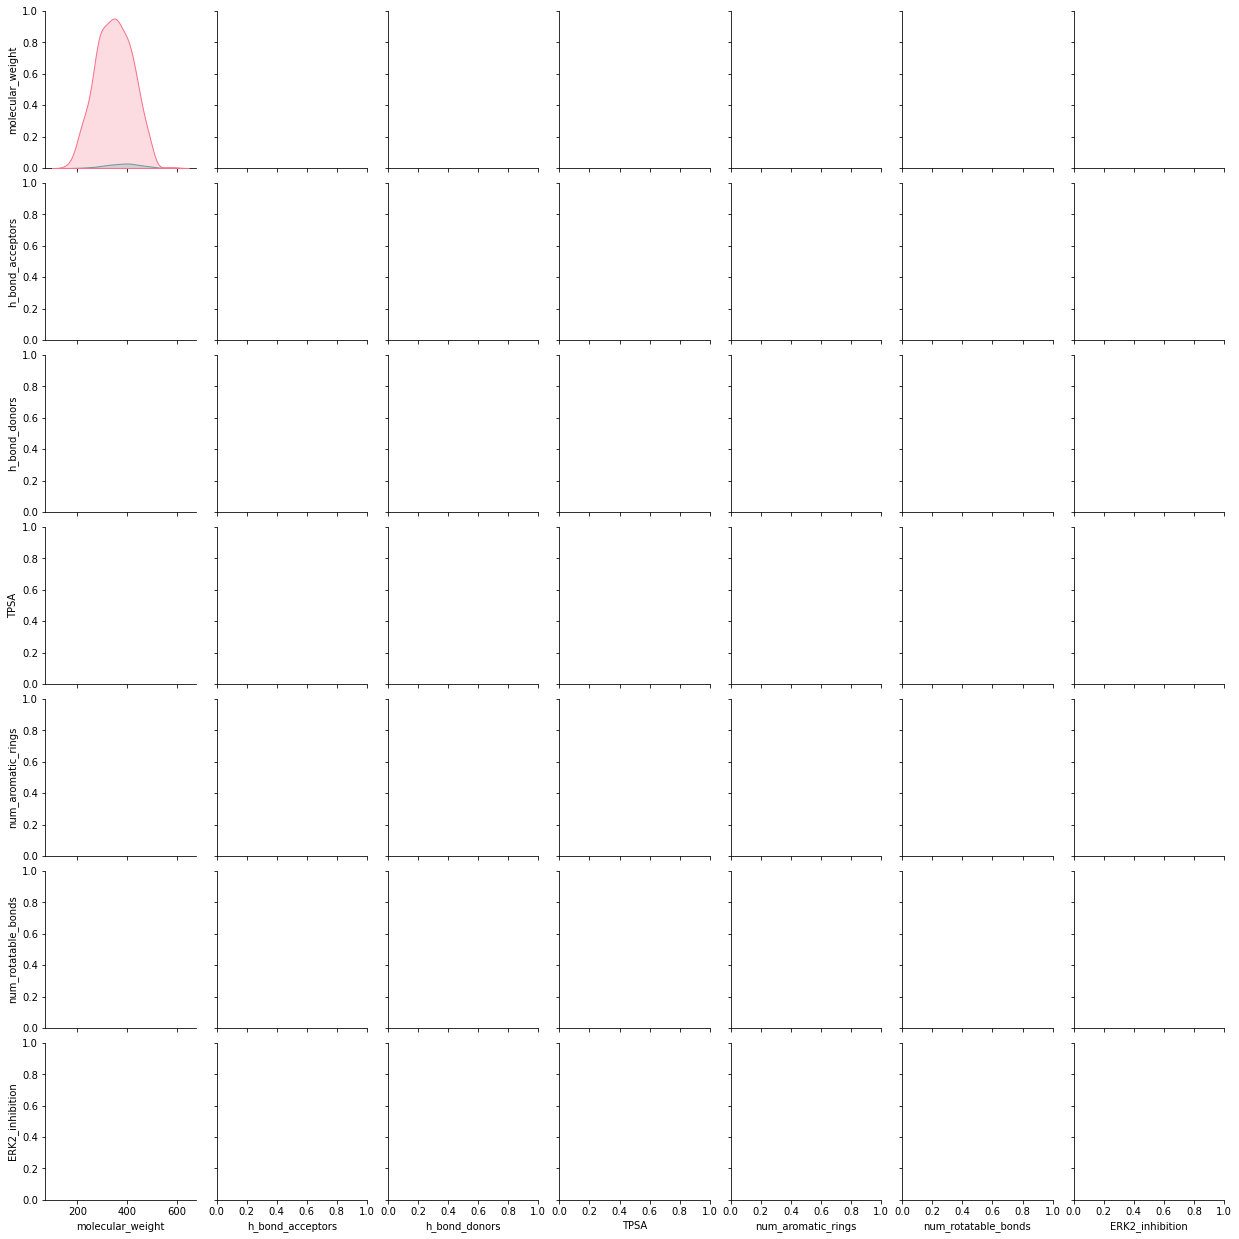

In [75]:
# Visualize distributions of molecular descriptors
plt.figure(figsize=(10, 6))
sns.histplot(data['molecular_weight'], kde=True)
plt.title('Distribution of Molecular Weight')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.show()

# Pair plots for molecular descriptors with color differentiation
sns.pairplot(data[["molecular_weight", "h_bond_acceptors", "h_bond_donors", "TPSA", "num_aromatic_rings", "num_rotatable_bonds", "PKM2_inhibition", "ERK2_inhibition"]], hue="PKM2_inhibition", palette="husl")
plt.show()

# Calculate the correlation matrix
corr_matrix = data[["PKM2_inhibition", "ERK2_inhibition", "molecular_weight", "h_bond_acceptors", "h_bond_donors", "TPSA", "num_aromatic_rings", "num_rotatable_bonds", "Morgan_Fingerprint", "MACCS_Keys"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Summarize and visualize fingerprint data
data['Morgan_Fingerprint'] = data['Morgan_Fingerprint'].apply(lambda x: np.array(x))
data['MACCS_Keys'] = data['MACCS_Keys'].apply(lambda x: np.array(x))

# Convert fingerprint columns to binary arrays
def convert_to_binary_array(row):
    return np.array(row)

data['Morgan_Fingerprint'] = data['Morgan_Fingerprint'].apply(convert_to_binary_array)
data['MACCS_Keys'] = data['MACCS_Keys'].apply(convert_to_binary_array)

# Example of visualizing the sum of fingerprint bits with color differentiation
morgan_sum = np.sum(np.stack(data['Morgan_Fingerprint'].values), axis=0)
maccs_sum = np.sum(np.stack(data['MACCS_Keys'].values), axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(morgan_sum)), morgan_sum, color=['blue' if i == 0 else 'red' for i in data['PKM2_inhibition']])
plt.title('Morgan Fingerprint Bit Counts')
plt.xlabel('Bit Position')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(range(len(maccs_sum)), maccs_sum, color=['blue' if i == 0 else 'red' for i in data['PKM2_inhibition']])
plt.title('MACCS Keys Bit Counts')
plt.xlabel('Bit Position')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [74]:
#Selecting the best descriptor
# For example, you can calculate correlation coefficients with the target categories
correlations_pkm = data.iloc[:, 3:].corrwith(data['PKM2_inhibition'], method='pearson')
correlations_erk = data.iloc[:, 3:].corrwith(data['ERK2_inhibition'], method='pearson')

# Get the absolute correlation values
correlations_pkm = correlations_pkm.abs().sort_values(ascending=False)
correlations_erk = correlations_erk.abs().sort_values(ascending=False)

# Select the descriptor with the highest correlation
best_descriptor_pkm = correlations_pkm.index[0]
best_descriptor_erk = correlations_erk.index[0]

# Visualization
# Define colors based on categories
colors = {
    (0, 0): 'blue',  # Both categories are 'No'
    (0, 1): 'green', # First category is 'No', second category is 'Yes'
    (1, 0): 'orange', # First category is 'Yes', second category is 'No'
    (1, 1): 'red'    # Both categories are 'Yes'
}

# Map categories to colors
category_colors = data[['PKM2_inhibition', 'ERK2_inhibition']].apply(lambda x: colors[(x[0], x[1])], axis=1)

# Plot pkm
plt.scatter(data[best_descriptor_pkm], data['PKM2_inhibition'], c=category_colors)
plt.xlabel(best_descriptor)
plt.ylabel('PKM2_inhibition')
plt.title('Visualization with Categorized Colors')
plt.show()

AttributeError: 'float' object has no attribute 'shape'